# Importacion Librerias

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [2]:
# Paleta colores para gráficos
color_azul_claro = "#4A90E2"
color_azul_oscuro = "#1F4E79"

## Carga Propensity_clean_v5.csv

In [3]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(BASE_DIR, "data", "processed")
file_name = "Propensity_clean_v5.csv"  
file_path = os.path.join(DATA_DIR, file_name)

df_5 = pd.read_csv(file_path)

# Carga Modelo Final

In [4]:
model_path = os.path.join(BASE_DIR, "data", "models_results", "results_v2.csv")
results_df_2 = pd.read_csv(model_path)
bmodel = results_df_2.loc[0]

In [5]:
bmodel

n_estimators             500
learning_rate            0.1
max_depth                  8
min_child_weight           3
gamma                    0.3
subsample                0.9
colsample_bytree         0.7
lambda                     1
alpha                      0
accuracy            0.875883
f1_score            0.875045
recall              0.875883
roc_auc             0.949423
cv_score            0.946107
train_score         0.973987
overfitting               OK
Name: 0, dtype: object

In [6]:
best_params = {
    'n_estimators': int(bmodel['n_estimators']),
    'learning_rate': float(bmodel['learning_rate']),
    'max_depth': int(bmodel['max_depth']),
    'min_child_weight': int(bmodel['min_child_weight']),
    'gamma': float(bmodel['gamma']),
    'subsample': float(bmodel['subsample']),
    'colsample_bytree': float(bmodel['colsample_bytree']),
    'reg_lambda': float(bmodel['lambda']),
    'reg_alpha': float(bmodel['alpha']),
}


best_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    **best_params
)

In [7]:
df_5 = df_5.drop(columns=["Tiempo"], errors="ignore")
y = df_5["Mas_1_coche"]
X = df_5.drop(columns=["Mas_1_coche"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [9]:
import joblib

# Guardar el modelo entrenado
joblib.dump(best_model, "modelo_xgboost.pkl")

['modelo_xgboost.pkl']

# Carga Prediciones

In [10]:

results_path = os.path.join(BASE_DIR, "data", "pred_results", "Propensity_Predictions_v2.csv")
pred = pd.read_csv(results_path)

In [11]:
pred.head()

,PRODUCTO,TIPO_CARROCERIA,COMBUSTIBLE,Potencia,TRANS,FORMA_PAGO,ESTADO_CIVIL,GENERO,OcupaciOn,PROVINCIA,...,Zona_Renta,REV_Garantia,Averia_grave,QUEJA_CAC,COSTE_VENTA,km_anno,Revisiones,Edad_Cliente,Prediccion,Probabilidad_Compra
0,0,0,0,0,1,3,0,1,1,26,...,2,0,0,0,2892,0,1,20,1,0.986447
1,0,0,0,0,1,3,3,1,1,38,...,0,1,1,0,2892,17967,1,55,1,0.859687
2,0,0,0,0,1,0,3,0,1,46,...,3,0,2,0,1376,0,1,18,0,0.010904
3,0,0,0,0,1,0,0,0,1,47,...,0,1,0,0,2594,6219,1,37,1,0.529952
4,0,0,0,0,1,3,0,0,1,8,...,3,0,3,1,1376,0,1,21,0,0.060663


# Gráficos Exploratorios

## Distrbucción de la Probilidad Compra

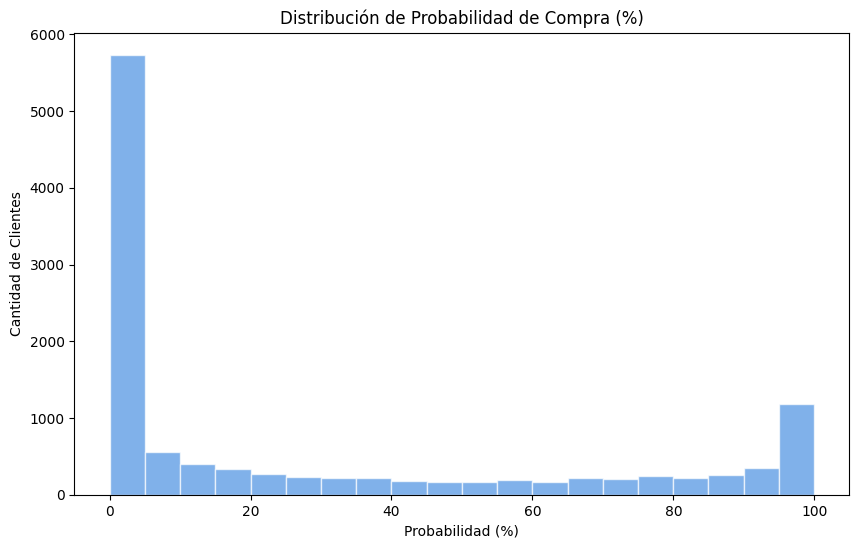

In [12]:
# tranformación a porcentaje de la colunmna Probabilidad Compra
pred['porcentaje'] = pred['Probabilidad_Compra'] * 100

#Histograma de la Distribución de Probabilidad de Compra
plt.figure(figsize=(10,6))
plt.hist(pred['porcentaje'], bins=20, edgecolor='white', alpha=0.7, color=color_azul_claro)
plt.title('Distribución de Probabilidad de Compra (%)')
plt.xlabel('Probabilidad (%)')
plt.ylabel('Cantidad de Clientes')
plt.show()


In [13]:
# Calcular estadísticas clave de la probabilidad de compra
print("Mínimo:", pred["Probabilidad_Compra"].min())
print("Media:", pred["Probabilidad_Compra"].mean())
print("Máximo:", pred["Probabilidad_Compra"].max())
print("Desviación Estándar:", pred["Probabilidad_Compra"].std())

Mínimo: 7.1982718e-06
Media: 0.28621782578798566
Máximo: 0.9998666
Desviación Estándar: 0.36605579154357964


## Gráfico Predicción

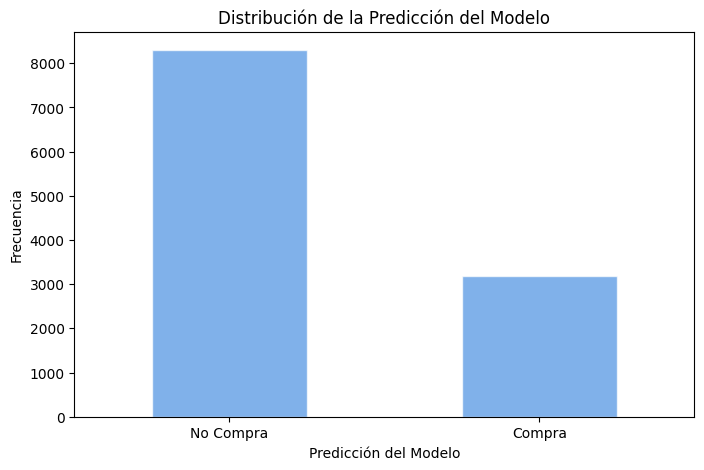

In [14]:
plt.figure(figsize=(8, 5))
ax = pred["Prediccion"].value_counts().sort_index().plot(kind="bar", color=color_azul_claro, edgecolor="white",alpha=0.7)


plt.xticks(ticks=[0, 1], labels=["No Compra", "Compra"], rotation=0)


plt.xlabel("Predicción del Modelo")
plt.ylabel("Frecuencia")
plt.title("Distribución de la Predicción del Modelo")
plt.show()

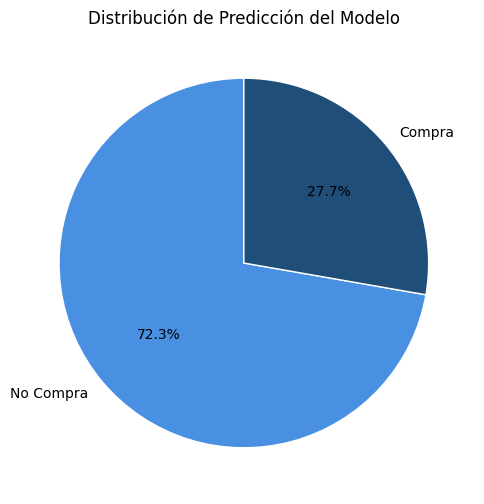

In [15]:
#grafico % de prediccion
plt.figure(figsize=(6, 6))
plt.pie(pred["Prediccion"].value_counts(normalize=True), labels=["No Compra", "Compra"], autopct="%1.1f%%", colors=[color_azul_claro, color_azul_oscuro], startangle=90, wedgeprops={"edgecolor": "white"})
plt.title("Distribución de Predicción del Modelo")


plt.show()

# Feature Importance Global

In [16]:
importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

feature_importance_df

,Feature,Importance
13,Zona_Renta,0.295625
12,Campanna3,0.100017
0,PRODUCTO,0.091894
5,FORMA_PAGO,0.067836
17,COSTE_VENTA,0.058013
10,Campanna1,0.044228
16,QUEJA_CAC,0.037163
18,km_anno,0.031380
1,TIPO_CARROCERIA,0.030169
15,Averia_grave,0.028583


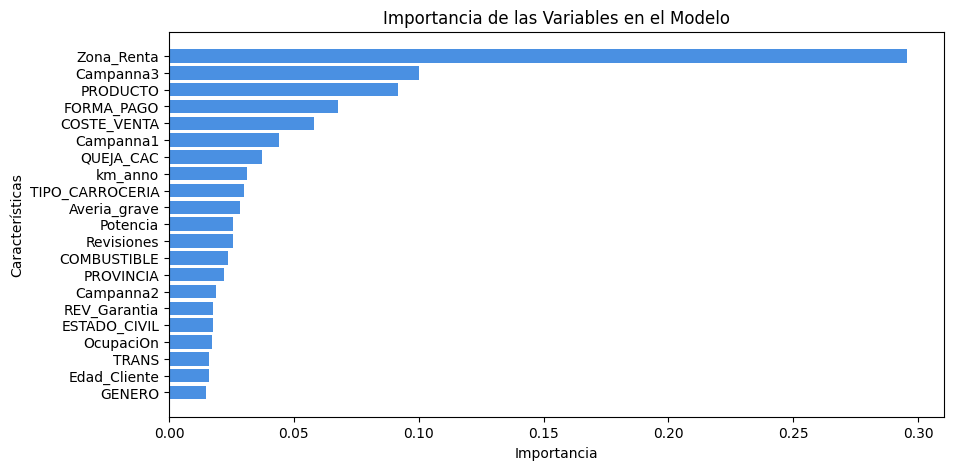

In [17]:
plt.figure(figsize=(10, 5))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color=color_azul_claro)
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.title("Importancia de las Variables en el Modelo")
plt.gca().invert_yaxis() 
plt.show()

# Segmentacion de los clientes

Los segmentos están definidos de la siguiente manera:

| **Segmento**                 | **Probabilidad de Compra** | **Descripción** |
|------------------------------|--------------------------|----------------|
| **Clientes Premium**         | 80% - 100%               | Son los clientes con mayor probabilidad de compra. Seguramente ya han interactuado con la marca, han mostrado interés o tienen un historial de compras. |
| **Clientes Potenciales**     | 50% - 80%                | Tienen una buena probabilidad de compra, pero puede que necesiten un empujón final, como descuentos o incentivos, para concretar la compra. |
| **Clientes Dudosos**         | 30% - 50%                | No están seguros de comprar. Pueden necesitar más información, comparaciones con la competencia o testimonios de otros clientes. |
| **Clientes No Interesados**  | 0% - 30%                 | Son clientes con baja probabilidad de compra. Puede que no estén en el momento adecuado para comprar o simplemente no tengan interés en el producto. |


In [18]:
probability_column = "Probabilidad_Compra" if "Probabilidad_Compra" in pred.columns else pred.columns[-1]
print(f"Usando la columna de probabilidad: {probability_column}")

def categorizar_cliente(probabilidad):
    if probabilidad >= 0.8:
        return "Premium"
    elif 0.5 <= probabilidad < 0.8:
        return "Potenciales"
    elif 0.3 <= probabilidad < 0.5:
        return "Dudosos"
    else:
        return "No Interesados"


pred["Tipo_Cliente"] = pred[probability_column].apply(categorizar_cliente)

# Contar cuántos clientes hay en cada segmento
segment_counts = pred["Tipo_Cliente"].value_counts()
print(segment_counts)

Usando la columna de probabilidad: Probabilidad_Compra
Tipo_Cliente
No Interesados    7537
Premium           2006
Potenciales       1181
Dudosos            761
Name: count, dtype: int64


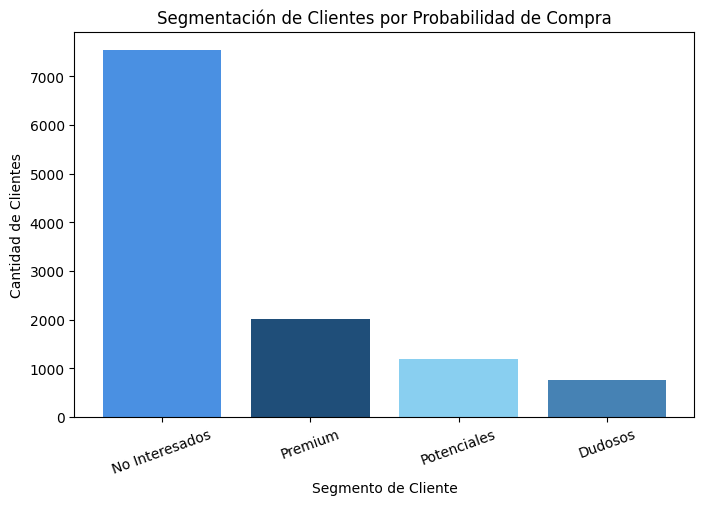

In [19]:
plt.figure(figsize=(8, 5))
plt.bar(segment_counts.index, segment_counts.values, color=['#4A90E2', '#1F4E79', '#89CFF0', '#4682B4'])
plt.xlabel("Segmento de Cliente")
plt.ylabel("Cantidad de Clientes")
plt.title("Segmentación de Clientes por Probabilidad de Compra")
plt.xticks(rotation=20)
plt.show()

In [20]:
df_analisis = pred.drop(columns=["Probabilidad_Compra", "Prediccion", "porcentaje"]).copy()
df_analisis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11485 entries, 0 to 11484
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   PRODUCTO         11485 non-null  int64 
 1   TIPO_CARROCERIA  11485 non-null  int64 
 2   COMBUSTIBLE      11485 non-null  int64 
 3   Potencia         11485 non-null  int64 
 4   TRANS            11485 non-null  int64 
 5   FORMA_PAGO       11485 non-null  int64 
 6   ESTADO_CIVIL     11485 non-null  int64 
 7   GENERO           11485 non-null  int64 
 8   OcupaciOn        11485 non-null  int64 
 9   PROVINCIA        11485 non-null  int64 
 10  Campanna1        11485 non-null  int64 
 11  Campanna2        11485 non-null  int64 
 12  Campanna3        11485 non-null  int64 
 13  Zona_Renta       11485 non-null  int64 
 14  REV_Garantia     11485 non-null  int64 
 15  Averia_grave     11485 non-null  int64 
 16  QUEJA_CAC        11485 non-null  int64 
 17  COSTE_VENTA      11485 non-null

## Comparativa de los grupos

### Variable Numéricas

En esta sección vamos a comparar la media de las variables númericas para tipo de perfil de clientes.

In [21]:
medias_tipo_cliente = df_analisis.groupby("Tipo_Cliente")[["COSTE_VENTA", "km_anno", "Revisiones", "Edad_Cliente"]].mean()
orden_tipo_cliente = ["No Interesados", "Dudosos", "Potenciales", "Premium"]
medias_tipo_cliente = medias_tipo_cliente.reindex(orden_tipo_cliente)

print("\n Comparación de variables numéricas por tipo de cliente \n")
display(medias_tipo_cliente)


 Comparación de variables numéricas por tipo de cliente 



,COSTE_VENTA,km_anno,Revisiones,Edad_Cliente
Tipo_Cliente,,,,
No Interesados,2289.448322,10733.643359,3.480165,47.243598
Dudosos,2470.802891,12246.578187,3.816032,47.834428
Potenciales,2591.881456,12166.459780,3.893311,47.447925
Premium,3595.759721,15379.604187,3.251745,47.180957


Conclusiones
- **Premium** → Mayor gasto y más kilómetros, pero menos revisiones.
- **Potenciales & Dudosos** → Gasto similar (Potenciales más que Dudoso), revisan más el coche (~3.8) y recorren menos km que Premium.
- **No Interesados** → Menor gasto  y menos kilómetros anuales.
- **Edad similar** en todos los grupos (~47 años).

## Variables Categóricas

En esta sección vamos a comparar la frecuencia relativa de las variables categóricas para cada tipo de cliente

In [22]:

variables_numericas = ["COSTE_VENTA", "km_anno", "Revisiones", "Edad_Cliente"]  
variables_categoricas = [col for col in df_analisis.columns if col not in variables_numericas + ["Tipo_Cliente"]]


orden_tipo_cliente = ["No Interesados", "Dudosos", "Potenciales", "Premium"]

print("\n Distribución de frecuencias para variables categóricas ")
for var in variables_categoricas:
    print(f"\nFrecuencia relativa de {var} por tipo de cliente:")
    
    # Agrupar por Tipo_Cliente y contar las frecuencias relativas
    tabla_frecuencia = df_analisis.groupby("Tipo_Cliente")[var].value_counts(normalize=True).unstack().reset_index()
    tabla_frecuencia = tabla_frecuencia.set_index("Tipo_Cliente").reindex(orden_tipo_cliente).reset_index()
    

    display(tabla_frecuencia)


 Distribución de frecuencias para variables categóricas 

Frecuencia relativa de PRODUCTO por tipo de cliente:


PRODUCTO,Tipo_Cliente,0,1,2,3,4,5,6,7,8,9,10
0,No Interesados,0.122197,0.284331,0.080403,0.113042,0.008226,0.000663,0.000398,0.061696,0.276768,0.050816,0.001459
1,Dudosos,0.128778,0.294350,0.089356,0.170828,0.006570,NaN,NaN,0.022339,0.231275,0.053876,0.002628
2,Potenciales,0.168501,0.318374,0.071126,0.160034,0.009314,NaN,NaN,0.019475,0.209992,0.042337,0.000847
3,Premium,0.094217,0.194417,0.046859,0.336989,0.026919,0.001496,0.000499,0.049850,0.228315,0.018445,0.001994



Frecuencia relativa de TIPO_CARROCERIA por tipo de cliente:


TIPO_CARROCERIA,Tipo_Cliente,0,1,2,3,4,5,6,7
0,No Interesados,0.380125,0.008226,0.000663,0.080403,0.000398,0.120207,0.390739,0.019238
1,Dudosos,0.454665,0.006570,NaN,0.089356,NaN,0.111695,0.310118,0.027595
2,Potenciales,0.472481,0.009314,NaN,0.071126,NaN,0.148180,0.272650,0.026249
3,Premium,0.401296,0.026919,0.001496,0.046859,0.000499,0.153041,0.298604,0.071286



Frecuencia relativa de COMBUSTIBLE por tipo de cliente:


COMBUSTIBLE,Tipo_Cliente,0,1
0,No Interesados,0.415417,0.584583
1,Dudosos,0.432326,0.567674
2,Potenciales,0.497036,0.502964
3,Premium,0.445663,0.554337



Frecuencia relativa de Potencia por tipo de cliente:


Potencia,Tipo_Cliente,0,1,2
0,No Interesados,0.126443,0.690726,0.182831
1,Dudosos,0.135348,0.675427,0.189225
2,Potenciales,0.176969,0.651143,0.171888
3,Premium,0.097707,0.693420,0.208873



Frecuencia relativa de TRANS por tipo de cliente:


TRANS,Tipo_Cliente,0,1
0,No Interesados,0.084384,0.915616
1,Dudosos,0.085414,0.914586
2,Potenciales,0.081287,0.918713
3,Premium,0.097208,0.902792



Frecuencia relativa de FORMA_PAGO por tipo de cliente:


FORMA_PAGO,Tipo_Cliente,0,1,2,3
0,No Interesados,0.515059,0.030383,0.276503,0.178055
1,Dudosos,0.592641,0.043364,0.206307,0.157687
2,Potenciales,0.573243,0.032176,0.207451,0.187130
3,Premium,0.494516,0.037388,0.271685,0.196411



Frecuencia relativa de ESTADO_CIVIL por tipo de cliente:


ESTADO_CIVIL,Tipo_Cliente,0,1,2,3
0,No Interesados,0.762372,0.022157,0.016452,0.199018
1,Dudosos,0.805519,0.019711,0.017083,0.157687
2,Potenciales,0.771380,0.022015,0.015241,0.191363
3,Premium,0.782154,0.026919,0.016451,0.174477



Frecuencia relativa de GENERO por tipo de cliente:


GENERO,Tipo_Cliente,0,1
0,No Interesados,0.295608,0.704392
1,Dudosos,0.296978,0.703022
2,Potenciales,0.317528,0.682472
3,Premium,0.244267,0.755733



Frecuencia relativa de OcupaciOn por tipo de cliente:


OcupaciOn,Tipo_Cliente,0,1,2
0,No Interesados,0.024811,0.923046,0.052143
1,Dudosos,0.019711,0.926413,0.053876
2,Potenciales,0.023709,0.911939,0.064352
3,Premium,0.033898,0.904786,0.061316



Frecuencia relativa de PROVINCIA por tipo de cliente:


PROVINCIA,Tipo_Cliente,0,1,2,3,4,5,6,7,8,...,42,43,44,45,46,47,48,49,50,51
0,No Interesados,0.018442,0.009155,0.041661,0.010349,0.020167,0.002123,0.009288,0.018442,0.126310,...,0.024811,0.000265,0.022157,0.004113,0.013666,0.046570,0.009818,0.029720,0.002123,0.024944
1,Dudosos,0.007884,0.001314,0.027595,0.003942,0.030223,NaN,0.005256,0.011827,0.207622,...,0.021025,NaN,0.026281,0.003942,0.010512,0.036794,0.009198,0.036794,NaN,0.019711
2,Potenciales,0.007621,0.007621,0.030483,0.009314,0.015241,0.001693,0.009314,0.013548,0.206605,...,0.025402,0.001693,0.012701,NaN,0.009314,0.034716,0.009314,0.025402,0.000847,0.020322
3,Premium,0.009472,0.005982,0.035892,0.008973,0.011964,0.000997,0.006979,0.018943,0.160518,...,0.018943,NaN,0.014955,0.002991,0.017946,0.028415,0.009970,0.023928,0.001994,0.018943



Frecuencia relativa de Campanna1 por tipo de cliente:


Campanna1,Tipo_Cliente,0,1
0,No Interesados,0.687939,0.312061
1,Dudosos,0.676741,0.323259
2,Potenciales,0.668078,0.331922
3,Premium,0.463609,0.536391



Frecuencia relativa de Campanna2 por tipo de cliente:


Campanna2,Tipo_Cliente,0,1
0,No Interesados,0.881783,0.118217
1,Dudosos,0.862024,0.137976
2,Potenciales,0.859441,0.140559
3,Premium,0.897308,0.102692



Frecuencia relativa de Campanna3 por tipo de cliente:


Campanna3,Tipo_Cliente,0,1
0,No Interesados,0.867056,0.132944
1,Dudosos,0.969777,0.030223
2,Potenciales,0.964437,0.035563
3,Premium,0.848953,0.151047



Frecuencia relativa de Zona_Renta por tipo de cliente:


Zona_Renta,Tipo_Cliente,0,1,2,3,4
0,No Interesados,0.129494,0.294812,0.245190,0.308345,0.022157
1,Dudosos,0.731932,0.034166,0.206307,0.022339,0.005256
2,Potenciales,0.705334,0.051651,0.205758,0.029636,0.007621
3,Premium,0.533400,0.148554,0.203888,0.100698,0.013460



Frecuencia relativa de REV_Garantia por tipo de cliente:


REV_Garantia,Tipo_Cliente,0,1
0,No Interesados,0.567865,0.432135
1,Dudosos,0.541393,0.458607
2,Potenciales,0.504657,0.495343
3,Premium,0.482054,0.517946



Frecuencia relativa de Averia_grave por tipo de cliente:


Averia_grave,Tipo_Cliente,0,1,2,3
0,No Interesados,0.501791,0.065543,0.114634,0.318031
1,Dudosos,0.500657,0.082786,0.131406,0.285151
2,Potenciales,0.559695,0.077053,0.145639,0.217612
3,Premium,0.538385,0.085743,0.137587,0.238285



Frecuencia relativa de QUEJA_CAC por tipo de cliente:


QUEJA_CAC,Tipo_Cliente,0,1
0,No Interesados,0.599045,0.400955
1,Dudosos,0.607096,0.392904
2,Potenciales,0.680779,0.319221
3,Premium,0.677966,0.322034


In [23]:

variables_numericas = ["COSTE_VENTA", "km_anno", "Revisiones", "Edad_Cliente"]
variables_categoricas = [col for col in df_analisis.columns if col not in variables_numericas + ["Tipo_Cliente"]]

## Perfil Clientes

## Producto

In [24]:
orden_tipo_cliente = ["No Interesados", "Dudosos", "Potenciales", "Premium"]
variable_a_analizar = "PRODUCTO"  

print(f"\nFrecuencia relativa de {variable_a_analizar} por tipo de cliente:")

tabla_frecuencia = df_analisis.groupby("Tipo_Cliente")[variable_a_analizar].value_counts(normalize=True).unstack().reset_index()

tabla_frecuencia = tabla_frecuencia.set_index("Tipo_Cliente").reindex(orden_tipo_cliente).reset_index()
display(tabla_frecuencia)


Frecuencia relativa de PRODUCTO por tipo de cliente:


PRODUCTO,Tipo_Cliente,0,1,2,3,4,5,6,7,8,9,10
0,No Interesados,0.122197,0.284331,0.080403,0.113042,0.008226,0.000663,0.000398,0.061696,0.276768,0.050816,0.001459
1,Dudosos,0.128778,0.294350,0.089356,0.170828,0.006570,NaN,NaN,0.022339,0.231275,0.053876,0.002628
2,Potenciales,0.168501,0.318374,0.071126,0.160034,0.009314,NaN,NaN,0.019475,0.209992,0.042337,0.000847
3,Premium,0.094217,0.194417,0.046859,0.336989,0.026919,0.001496,0.000499,0.049850,0.228315,0.018445,0.001994


In [25]:
variable_categorica = "PRODUCTO"  

# Orden para los tipos de clientes
orden_tipo_cliente = ["No Interesados", "Dudosos", "Potenciales", "Premium"]
for tipo_cliente in orden_tipo_cliente:
    
    df_filtrado = df_analisis[df_analisis["Tipo_Cliente"] == tipo_cliente]
    top3_productos = df_filtrado[variable_categorica].value_counts(normalize=True).head(3) * 100

    top3_productos = top3_productos.reset_index()
    top3_productos.columns = [variable_categorica, "Frecuencia (%)"]
    
    # Mostrar título y tabla específica para cada tipo de cliente
    print(f"\nTop 3 productos más comprados por '{tipo_cliente}':")
    display(top3_productos)


Top 3 productos más comprados por 'No Interesados':


,PRODUCTO,Frecuencia (%)
0,1,28.433064
1,8,27.676794
2,0,12.219716



Top 3 productos más comprados por 'Dudosos':


,PRODUCTO,Frecuencia (%)
0,1,29.434954
1,8,23.127464
2,3,17.082786



Top 3 productos más comprados por 'Potenciales':


,PRODUCTO,Frecuencia (%)
0,1,31.837426
1,8,20.999153
2,0,16.850127



Top 3 productos más comprados por 'Premium':


,PRODUCTO,Frecuencia (%)
0,3,33.698903
1,8,22.831505
2,1,19.441675


## 📊 **Patrones Identificados**
1. **El Producto 1 domina en los tres primeros segmentos**, pero pierde relevancia en clientes Premium.
2. **El Producto 3 es el más comprado por los clientes Premium (33.69%)**, lo que sugiere que es un producto de gama alta.
3. **El Producto 8 es consistente en todos los segmentos**, lo que indica que tiene buena aceptación general.
4. **El Producto 0 es clave para No Interesados y Potenciales**, pero no es relevante para Premium.



## 🎯 **Recomendaciones Estratégicas**
✅ **Para atraer a No Interesados y Dudosos**, reforzar campañas promocionales del **Producto 1**.  
✅ **Para convertir Potenciales en Premium**, destacar los beneficios exclusivos del **Producto 3**.  
✅ **Para los Premium**, centrar la estrategia en el **Producto 3** y su valor diferencial.  
✅ **Si se busca un producto versátil, el Producto 8** puede ser una buena opción para todos los segmentos.  

## Potencia

## 📊 **Patrones Identificados en Potencia por Tipo de Cliente**
- **La mayoría de los clientes prefieren Potencia Media (~65-70%)**, lo que indica que no es un factor clave de diferenciación.  
- **Los Premium tienen mayor inclinación por Potencia Alta (20.88%)**, mientras que los No Interesados presentan el menor porcentaje (18.28%).  
- **Los No Interesados tienen mayor presencia en Potencia Baja (12.64%)**, lo que sugiere que buscan opciones más económicas.  
- **Los Potenciales tienen una distribución más balanceada**, sin una preferencia clara por un nivel de potencia específico.  



## 🎯 **Recomendaciones Estratégicas**
✅ **Para convertir Potenciales en Premium**, resaltar modelos de **Potencia Alta**, ya que es donde más se diferencian.  
✅ **Para atraer a No Interesados**, enfocar estrategias en **modelos de Potencia Media y Baja** con buena relación calidad-precio. 

## Genero 

## 📊 **Patrones Identificados en GÉNERO**
- La mayoría de los clientes pertenecen al grupo **1 (~70-75%)**, con una mayor concentración en **Premium (75.57%)**.    
- **El grupo 0 (posiblemente Femenino) tiene menor presencia en todos los segmentos**, siendo más bajo en Premium (24.43%).  

## 🎯 **Recomendaciones Estratégicas**
✅ **Los clientes Premium están dominados por el grupo 1**, lo que sugiere que es el perfil más propenso a realizar compras.   
✅ **Si se busca mayor equilibrio, explorar estrategias para atraer más clientes del grupo 0.**  

## Campaña 1

## 📊 **Patrones Identificados en Campaña 1 (Descuento por Financiar)**
- **La mayoría de No Interesados, Dudosos y Potenciales no aprovechan el descuento (~67-69%)**.  
- **En Premium, más de la mitad (53.64%) sí utilizan la campaña**, lo que indica que valoran el beneficio de financiar.  
- **A medida que el cliente avanza en el interés de compra, aumenta la proporción de quienes aprovechan el descuento**.  


## 🎯 **Recomendaciones Estratégicas**
✅ **El descuento por financiar es más atractivo para clientes Premium.**  
✅ **Para convertir Potenciales en Premium, resaltar este beneficio en la estrategia comercial.**  
✅ **Para atraer a No Interesados y Dudosos, mejorar la comunicación del descuento o explorar otros incentivos.**  

## Campaña 2

## 📊 **Patrones Identificados en Campaña 2 (Descuento por Adquirir un Seguro)**
- **La mayoría de los clientes no aprovechan el descuento (~86-89%) en todos los segmentos**.  
- **Los Premium son los que menos lo utilizan (10.27%)**, lo que indica que este incentivo no es relevante para ellos.  
- **Los Potenciales y Dudosos lo aprovechan en mayor medida (~14%), aunque la diferencia no es significativa**.  

## 🎯 **Recomendaciones Estratégicas**
✅ **Dado el bajo impacto de esta campaña, podría ser más eficiente eliminarla y redirigir la inversión a otros incentivos más atractivos.**  
✅ **Explorar qué beneficios valoran más los clientes (ej. descuentos directos en el vehículo o financiamiento flexible).**  
✅ **Si se mantiene, reformular la oferta para hacerla más atractiva, por ejemplo, incluyendo seguros con coberturas adicionales o mayor flexibilidad.**  

## Campaña 3

## 📊 **Patrones Identificados en Campaña 3**
- **La mayoría de los clientes no aprovechan esta campaña (~85-97%)**, con menor uso en Dudosos (3.02%) y Potenciales (3.55%).  
- **Los Premium la utilizan un poco más (15.10%)**, aunque sigue siendo una minoría.  
- **Dudosos y Potenciales prácticamente no la consideran, lo que sugiere que no es un incentivo relevante para estos segmentos.**  



## 🎯 **Recomendaciones Estratégicas**
✅ **La baja adopción indica que esta campaña podría no ser efectiva y su presupuesto podría redirigirse a incentivos más atractivos.**  
✅ **Si se mantiene, se debería analizar qué aspectos valoran los Premium para potenciar su impacto en otros segmentos.**  
✅ **Para atraer a No Interesados y Dudosos, se podrían explorar alternativas más alineadas con sus necesidades.**  

## Zona Renta

## 📊 **Perfiles de Clientes según Zona_Renta**
### 🟢 **Cliente Premium**  
- **Mayoría en Zona 0 (Alto, 53.34%)**, lo que indica que este segmento proviene principalmente de áreas de alta renta.  
- **También hay presencia en Zona 2 (Medio, 20.38%) y Zona 1 (Desconocido, 14.85%)**, lo que sugiere que algunos Premium también provienen de zonas con renta media o sin información clara.  
- **Baja representación en Zona 3 (Medio-Bajo, 10.07%) y Zona 4 (Otros, 1.34%)**, por lo que es menos común que clientes de menor renta lleguen a ser Premium.  



### 🟡 **Cliente Potencial**  
- **Gran parte se encuentra en Zona 0 (Alto, 70.53%)**, similar a los Premium, lo que indica que muchas personas con intención de compra provienen de áreas de alta renta.  
- **Presencia menor en Zona 2 (Medio, 20.57%)**, lo que sugiere que algunos clientes con intención de compra también están en áreas de renta media.  
- **Escasa representación en otras zonas, especialmente en Zona 3 (Medio-Bajo, 2.96%) y Zona 4 (Otros, 0.76%)**.  



### 🟠 **Cliente Dudoso**  
- **Mayor concentración en Zona 0 (Alto, 73.19%)**, lo que indica que la mayoría de estos clientes proviene de áreas de mayor renta, aunque aún no están convencidos de comprar.  
- **Poca representación en otras zonas**, con una leve presencia en Zona 2 (Medio, 20.63%).  
- **Las Zonas 3 (Medio-Bajo, 2.23%) y 4 (Otros, 0.52%) apenas tienen clientes en este grupo.**  



### 🔴 **Cliente No Interesado**  
- **Distribución más equilibrada en comparación con otros segmentos**.  
- **Zona 3 (Medio-Bajo, 30.83%) y Zona 1 (Desconocido, 29.48%) tienen una mayor concentración**, lo que indica que estos clientes provienen principalmente de áreas de menor renta o sin información clara.  
- **Menor presencia en Zona 0 (Alto, 12.95%)**, lo que sugiere que los clientes de renta alta tienen más interés en la compra.  



## 🎯 **Conclusiones Generales**
✅ **Los clientes Premium, Potenciales y Dudosos provienen en su mayoría de la Zona 0 (Alto), lo que indica que la renta alta está asociada con una mayor propensión a comprar.**  
✅ **Los No Interesados son los únicos con mayor representación en zonas de renta más baja o desconocida (Zonas 3 y 1).**  
✅ **Para aumentar la conversión de Potenciales a Premium, se podría analizar qué diferencia a estos clientes dentro de la Zona 0.**  
✅ **Si se quiere atraer más clientes Premium desde zonas de renta media o baja, habría que evaluar qué barreras existen en estas áreas y cómo superarlas.**  

## REV_GARANTIA

## 📊 **Patrones Identificados en REV_Garantia (Coche en Garantía)**
- **Los clientes Premium son los únicos donde la mayoría de los vehículos están en garantía (51.79%)**, lo que sugiere que este segmento compra coches más nuevos o con cobertura.  
- **Los Potenciales están más equilibrados (50.46% sin garantía vs. 49.53% con garantía), lo que indica que algunos consideran la garantía un factor importante.**  
- **Los Dudosos y No Interesados tienen una mayor proporción de coches sin garantía (~54-56%)**, lo que podría significar que valoran menos este aspecto o tienen coches más antiguos.  



## 🎯 **Conclusiones y Estrategias**
✅ **La garantía parece ser un factor relevante para los clientes Premium**, por lo que se puede destacar este beneficio en estrategias de venta.  
✅ **Para convertir Potenciales en Premium, reforzar la importancia de la garantía como elemento diferenciador.**  
✅ **Los No Interesados y Dudosos pueden estar menos preocupados por la garantía, por lo que otros incentivos (financiamiento o descuentos) podrían ser más efectivos para atraerlos.**  

## Averias

## 📊 **Patrones Identificados en Avería Grave**
- **La mayoría de los clientes en todos los segmentos no han experimentado averías graves (~50-55%).**  
- **Los No Interesados y Dudosos tienen una mayor proporción de averías de tipo 2 (graves) y 3 (muy graves)** en comparación con Potenciales y Premium.  
- **Los clientes Premium y Potenciales presentan menos averías graves, lo que podría estar relacionado con la antigüedad y mantenimiento de sus vehículos.**  



## 🎯 **Conclusiones y Estrategias**
✅ **Las averías graves podrían estar frenando la compra en los segmentos de No Interesados y Dudosos**, ya que han experimentado más problemas mecánicos.  
✅ **Para mejorar la conversión de estos clientes, se pueden resaltar garantías extendidas, programas de mantenimiento o beneficios en reparaciones.**  
✅ **Los Premium y Potenciales presentan menos averías, lo que puede estar asociado a la compra de vehículos más nuevos o mejor mantenidos.**  

## QUEJA CAC

## 📊 **Patrones Identificados en QUEJA_CAC (Llamadas al Centro de Atención al Cliente)**
- **Los clientes Potenciales (31.92%) y Premium (32.20%) son los que menos han contactado con el centro de atención**, lo que sugiere que tienen menos problemas o menos necesidad de asistencia.  
- **Los No Interesados (40.09%) y Dudosos (39.29%) han llamado con mayor frecuencia**, lo que puede indicar que han tenido más dudas, problemas o insatisfacción con el servicio.  


## 🎯 **Conclusiones y Estrategias**
✅ **El contacto con el CAC puede estar relacionado con experiencias negativas o dudas que frenan la compra, especialmente en No Interesados y Dudosos.**  
✅ **Mejorar la comunicación y resolución de problemas en estos segmentos podría ayudar a convertir más clientes.**  
✅ **Los Premium y Potenciales requieren menos asistencia, lo que podría estar asociado con una mejor experiencia de compra o un menor número de problemas.**  

## Perfil Comprador no Comprador 

## Variables Numéricas

In [26]:
media_variables = pred.groupby("Prediccion")[variables_numericas].mean().reset_index()
media_variables.index = [""] * len(media_variables)


display(media_variables)

,Prediccion,COSTE_VENTA,km_anno,Revisiones,Edad_Cliente
,0,2306.080140,10872.392866,3.510966,47.297783
,1,3223.754628,14188.915908,3.489489,47.279887



- Los compradores tienen un mayor coste de venta en comparación con los no compradores.  
- También presentan un mayor kilometraje anual, lo que sugiere que los clientes que usan más el coche están más dispuestos a comprar.  
- No hay una diferencia significativa en la cantidad de revisiones entre ambos grupos, por lo que esta variable no parece influir en la decisión de compra.  